In [1]:
import cv2
import numpy as np
import napari
from matplotlib import pyplot as plt
from skimage.measure import label, regionprops

def analyze_petri_dish(image_path):
    """
    Analyze the spots within a Petri dish image and display results.

    Args:
        image_path (str): Path to the input Petri dish image.

    Returns:
        int: Number of spots detected in the Petri dish.
    """
    # Step 1: Read the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load the image. Check the file path.")
        return
    
    # Step 2: Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 3: Threshold to create a binary mask
    _, binary = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    # Step 4: Find the largest contour (assumed to be the Petri dish)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours detected in the image.")
        return
    largest_contour = max(contours, key=cv2.contourArea)

    # Step 5: Create a mask for the Petri dish and crop it
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=-1)
    isolated = cv2.bitwise_and(image, image, mask=mask)

    # Step 6: Crop the bounding box
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped = isolated[y:y+h, x:x+w]

    # Step 7: Preprocess the cropped image for spot detection
    gray_cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_cropped, (5, 5), 0)
    adaptive_thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 5
    )

    # Step 8: Clean binary mask with morphological operations
    kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Step 9: Label connected components and filter small/large regions
    labeled_image = label(cleaned)
    props = regionprops(labeled_image)

    area_min, area_max = 5, 1000  # Set area thresholds for valid spots
    filtered_image = np.zeros_like(cleaned)
    for region in props:
        if area_min < region.area < area_max:
            filtered_image[labeled_image == region.label] = 255

    # Step 10: Count spots
    valid_spots = [region for region in props if area_min < region.area < area_max]
    num_spots = len(valid_spots)
    print(f"Total spots found: {num_spots}")

    # Step 11: Draw contours around the spots
    spots_contours, _ = cv2.findContours(filtered_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output_image = cropped.copy()
    cv2.drawContours(output_image, spots_contours, -1, (0, 255, 0), 2)

    # Step 12: Display results using Matplotlib
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Isolated Petri Dish")
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(f"Spots Count: {num_spots}")
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Step 13: Visualize with Napari
    with napari.gui_qt():
        viewer = napari.Viewer()
        viewer.add_image(image, rgb=True, name="Original Image")
        viewer.add_image(cleaned, colormap="gray", name="Cleaned Mask")
        viewer.add_labels(filtered_image, name="Filtered Spots")

        # Add centroids of the spots as points
        centroids = np.array([region.centroid for region in valid_spots])
        if centroids.size > 0:
            viewer.add_points(centroids, size=5, face_color="red", name="Spot Centroids")

    return num_spots


Total spots found: 1430


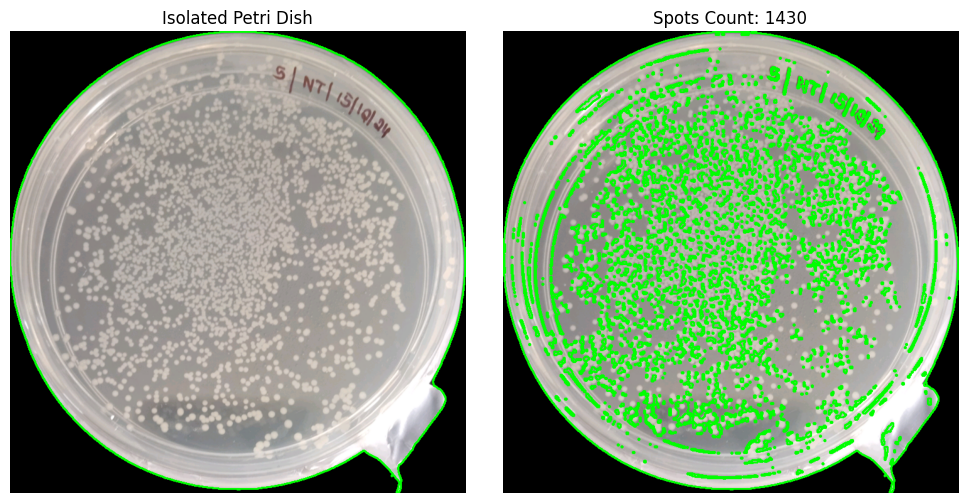

C:\Users\shive\anaconda3\Lib\contextlib.py:137: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  return next(self.gen)
C:\Users\shive\anaconda3\Lib\site-packages\napari\_qt\qt_event_loop.py:306: FutureWarning: `QApplication` instance access through `get_app` is deprecated and will be removed in 0.6.0.
Please use `get_qapp` instead.

  app = get_app()


Detected 1430 spots in the Petri dish.


In [2]:
image_path = r"C:\Users\shive\OneDrive\Pictures\Screenshots\isolated_spots.png"
num_spots = analyze_petri_dish(image_path)
print(f"Detected {num_spots} spots in the Petri dish.")
